In [2]:
# 一、导入库和模块
import math
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn import model_selection
from sklearn import tree
from sklearn import ensemble
from sklearn import linear_model
from xgboost import XGBRegressor
plt.rcParams['font.sans-serif'] = ['SimHei']
plt.rcParams['axes.unicode_minus'] = False

In [3]:
# 二、导入归一化后的solo-fpp数据并查看数据概况
data = pd.read_csv('../1-Data_Set/data_solo_trait_ten.csv')
data.head()

,winPlacePerc,walkDistance,boosts,weaponsAcquired,kda,damageDealt,killStreaks,longestKill,heals,rideDistance,headshotKills
0,0.8462,0.126073,0.055556,0.057692,0.047619,0.043995,0.076923,0.023050,0.000000,0.00000,0.0
1,0.2245,0.038936,0.000000,0.057692,0.000000,0.007835,0.000000,0.000000,0.000000,0.00408,0.0
2,0.1573,0.019117,0.055556,0.076923,0.047619,0.043995,0.076923,0.008317,0.000000,0.00000,0.0
3,0.1075,0.024142,0.000000,0.019231,0.000000,0.015838,0.000000,0.000000,0.000000,0.00000,0.0
4,0.9355,0.157838,0.055556,0.153846,0.142857,0.103828,0.076923,0.012713,0.142857,0.00000,0.0


In [4]:
# 三、建立模型评估列表
list_scores = [] #存储使用模型的正确率列表
list_mse = [] #存储使用模型的平均平方误差列表

In [5]:
# 四、决策树模型（DecisionTreeRegressor）
#参数参考链接:https://blog.csdn.net/u013344884/article/details/79276825






max_score:  0.7277086655013624
max_random_state:  29


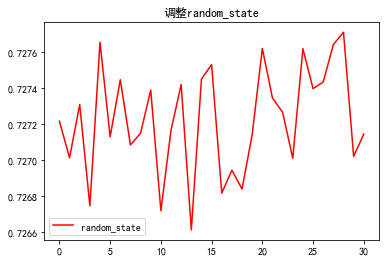

In [6]:
# 1.决策树调整第一步，调整random_state（不使用交叉验证是因为交叉验证在回归类模型无法得到正确率，其判断标准为均方误差不如正确率直观）

# 划分特征矩阵与预测矩阵
X = data.iloc[:,1:].values
y = data.iloc[:,0].values.reshape(-1,1)

# 划分训练集和测试集
x_train, x_test, y_train, y_test = model_selection.train_test_split(X,y,test_size=0.3)

# 定义计算正确率函数（回归树的接口score返回的是R平方，并不是MSE）
#原理有很多数学公式，jupyter打不出来，推荐直接看视频学习
#原理链接:https://www.bilibili.com/video/BV1WJ411k7L3?p=8
def get_score(y_test,pre):
    error_sum = 0
    for i,j in zip(y_test,pre):
        error_sum+=math.sqrt((i-j)**2)
    pre_sum=sum(pre)
    score = (1-(error_sum/pre_sum)) #R*2 = 1-u/v,其中u是残差平方和（MSE * N），v是总平方和
    return score

scores = [] #定义准确率列表
for i in range(31):
    # 实例化模型并训练
    regressor = tree.DecisionTreeRegressor(random_state=i)
    regressor.fit(x_train,y_train)
    pre = regressor.predict(x_test)
    
    #调用函数计算正确率并添加至列表
    score = get_score(y_test,pre)
    scores.append(score)
print('max_score:'+'  '+str(max(scores))) #打印准确率最大值
print('max_random_state:'+'  '+str(np.argmax(scores)+1)) #打印准确率最大值索引
    
#绘制图片
plt.plot(range(31),scores,color="red",label="random_state")
plt.title('调整random_state')
plt.legend()
plt.savefig('./images/solo-fpp/决策树/solo_fpp_DTR_random_state.png')
plt.show()

#random_state最优值为29

In [8]:
# 2.决策树调整第二步,调整splitter
scores = [] #定义准确率列表
splitters = ['random','best']
for i in splitters:
    regressor = tree.DecisionTreeRegressor(random_state=29
                                          ,splitter=i
                                          ) #实例化模型
    regressor.fit(x_train,y_train) #训练模型
    pre = regressor.predict(x_test) #获取R*2
    score = get_score(y_test,pre) #调用函数计算正确率

    scores.append(score) #将正确率添加至列表
[*zip(splitters,scores)] #惰性函数zip将splitters与scores展示

#默认的"best"适合样本量不大的时候，而如果样本数据量非常大，此时决策树构建推荐"random" ，故splitter参数选择random

[('random', 0.7271385650702411), ('best', 0.727019799618156)]

max_score:  0.7946458199148208
max_max_depth:  12


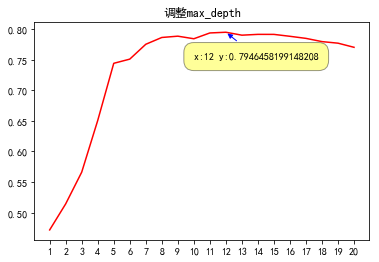

In [9]:
# 3.决策树调整第三步,调整max_depth
#求解参数max_depth最优值
scores = []
for i in range(20):
    regressor = tree.DecisionTreeRegressor(random_state=29
                                           ,splitter='random'
                                           ,max_depth=i+1
                                          )
    regressor.fit(x_train,y_train)
    pre = regressor.predict(x_test)
    score = get_score(y_test,pre)
    scores.append(score)
print('max_score:'+'  '+str(max(scores))) #打印准确率最大值
print('max_max_depth:'+'  '+str(np.argmax(scores)+1)) #打印准确率最大值索引

#绘制图片
plt.plot(range(1,21),scores,color="red") 
plt.xticks(range(1,21))
plt.annotate(s='x:'+str(np.argmax(scores)+1)+' '+'y:'+str(max(scores)),xy=(np.argmax(scores)+1,max(scores)),xytext=(10,0.75),
             weight='bold',color='black',arrowprops=dict(arrowstyle='-|>',connectionstyle='arc3',color='blue'),\
             bbox=dict(boxstyle='round,pad=1.0', fc='yellow', ec='k',lw=1 ,alpha=0.4))
plt.title('调整max_depth')
plt.savefig('./images/solo-fpp/决策树/solo_fpp_DTR_max_depth.png')
plt.show()

#决策树的最大深度，值为12时准确率最高

max_score:  0.7952975596845367
max_min_samples_split:  8


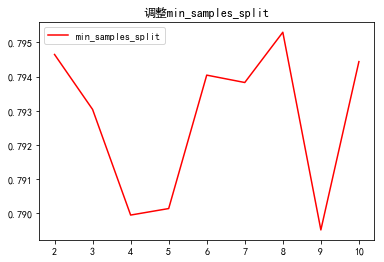

In [10]:
# 4.决策树调整第四步,调整min_samples_split
#求解min_samples_split最优值
scores = []
for i in range(2,11):
    regressor = tree.DecisionTreeRegressor(random_state=29
                                           ,splitter='random'
                                           ,max_depth=12
                                           ,min_samples_split=i
                                          )
    regressor.fit(x_train,y_train)
    pre = regressor.predict(x_test)
    score = get_score(y_test,pre)
    scores.append(score)
print('max_score:'+'  '+str(max(scores)))
print('max_min_samples_split:'+'  '+str(np.argmax(scores)+2))

#绘制图片
plt.plot(range(2,11),scores,color="red",label="min_samples_split")
plt.title('调整min_samples_split')
plt.legend()
plt.savefig('./images/solo-fpp/决策树/solo_fpp_DTR_min_samples_split.png')
plt.show()

#内部节点再划分所需最小样本数，默认是2，由图知8的准确率最高

max_score:  0.7959519305930778
max_min_samples_leaf:  4


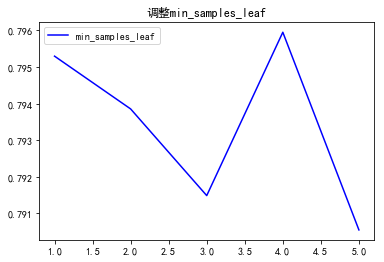

In [11]:
# 5.决策树调整第五步,调整min_samples_leaf
#求解min_samples_leaf最优值
scores = []
for i in range(1,6):
    regressor = tree.DecisionTreeRegressor(random_state=29
                                           ,splitter='random'
                                           ,max_depth=12
                                           ,min_samples_split=8
                                           ,min_samples_leaf=i
                                          )
    regressor.fit(x_train,y_train)
    pre = regressor.predict(x_test)
    score = get_score(y_test,pre)
    scores.append(score)
print('max_score:'+'  '+str(max(scores)))
print('max_min_samples_leaf:'+'  '+str(np.argmax(scores)+1))

#绘制图片
plt.plot(range(1,6),scores,color="blue",label="min_samples_leaf")
plt.title('调整min_samples_leaf')
plt.legend()
plt.savefig('./images/solo-fpp/决策树/solo_fpp_DTR_min_samples_leaf.png')
plt.show()

#叶子节点最少样本数,默认是1，为4时准确率最高

max_score:  0.7347562001285675
max_max_leaf_nodes:  19


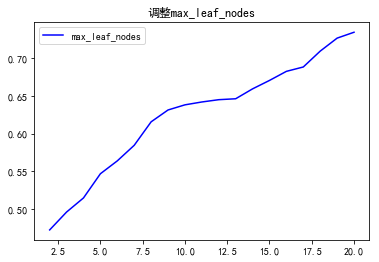

In [12]:
# 6.决策树调整第六步,调整max_leaf_nodes
#求解max_leaf_nodes最优值
scores = []
for i in range(2,21):
    regressor = tree.DecisionTreeRegressor(random_state=29
                                           ,splitter='random'
                                           ,max_depth=12
                                           ,min_samples_split=8
                                           ,min_samples_leaf=4
                                           ,max_leaf_nodes=i
                                          )
    regressor.fit(x_train,y_train)
    pre = regressor.predict(x_test)
    score = get_score(y_test,pre)
    scores.append(score)
print('max_score:'+'  '+str(max(scores)))
print('max_max_leaf_nodes:'+'  '+str(np.argmax(scores)+1))

#绘制图片
plt.plot(range(2,21),scores,color="blue",label="max_leaf_nodes")
plt.title('调整max_leaf_nodes')
plt.legend()
plt.savefig('./images/solo-fpp/决策树/solo_fpp_DTR_max_leaf_nodes.png')
plt.show()

#最大叶子节点数，默认是"None”，由图知值为19时最高，但准确率反而下降了，虽然继续增大可以提升准确率，但效果不大，故采用None

In [13]:
# 7.存储正确率和mse至列表
# 定义模型
regressor = tree.DecisionTreeRegressor(random_state=29
                                           ,splitter='random'
                                           ,max_depth=12
                                           ,min_samples_split=8
                                           ,min_samples_leaf=4
                                          )
# 实例化模型并存储准确率
regressor.fit(x_train,y_train)
pre = regressor.predict(x_test)
score = get_score(y_test,pre)
list_scores.append(score)

# 使用交叉验证实例化模型并存储mse
mse = model_selection.cross_val_score(regressor, X, y, cv=10,scoring = "neg_mean_squared_error").mean()
list_mse.append(mse)

In [14]:
# 五、随机森林模型（RandomForestRegressor）
#参数参考链接:https://blog.csdn.net/iModel/article/details/80042862





D:\ANACONDA\lib\site-packages\ipykernel_launcher.py:26: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
D:\ANACONDA\lib\site-packages\ipykernel_launcher.py:26: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
D:\ANACONDA\lib\site-packages\ipykernel_launcher.py:26: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
D:\ANACONDA\lib\site-packages\ipykernel_launcher.py:26: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
D:\ANACONDA\lib\site-packages\ipykernel_launcher.py:26: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the 

max_score:  0.7924540426049267
max_random_state:  15


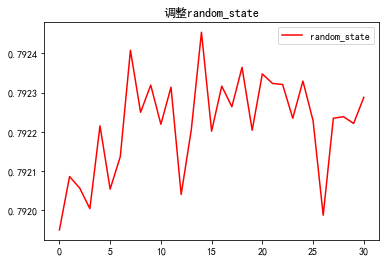

In [15]:
# 1.随机森林调整第一步，调整random_state（运行时间约35分钟）

# 划分特征矩阵与预测矩阵
X = data.iloc[:,1:].values
y = data.iloc[:,0].values.reshape(-1,1)

# 划分训练集和测试集
x_train, x_test, y_train, y_test = model_selection.train_test_split(X,y,test_size=0.3)

# 定义计算正确率函数（RandomForestRegressor的接口score返回的是R平方，并不是MSE）
#原理有很多数学公式，jupyter打不出来，推荐直接看视频学习
#原理链接:https://www.bilibili.com/video/BV1WJ411k7L3?p=20
def get_score(y_test,pre):
    error_sum = 0
    for i,j in zip(y_test,pre):
        error_sum+=math.sqrt((i-j)**2)
    pre_sum=sum(pre)
    score = (1-(error_sum/pre_sum)) #R*2 = 1-u/v,其中u是残差平方和（MSE * N），v是总平方和
    return score

# 获取random_state最优值
scores = [] #定义准确率列表
for i in range(31):
    # 实例化模型并训练
    regressor = ensemble.RandomForestRegressor(random_state=i)
    regressor.fit(x_train,y_train)
    pre = regressor.predict(x_test)
    
    #调用函数计算正确率并添加至列表
    score = get_score(y_test,pre)
    scores.append(score)
print('max_score:'+'  '+str(max(scores))) #打印准确率最大值
print('max_random_state:'+'  '+str(np.argmax(scores)+1)) #打印准确率最大值索引
    
#绘制图片
plt.plot(range(31),scores,color="red",label="random_state")
plt.title('调整random_state')
plt.legend()
plt.savefig('./images/solo-fpp/随机森林/solo_fpp_RFR_random_state.png')
plt.show()

#random_state最优值为15

D:\ANACONDA\lib\site-packages\ipykernel_launcher.py:9: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  if __name__ == '__main__':
D:\ANACONDA\lib\site-packages\ipykernel_launcher.py:9: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  if __name__ == '__main__':
D:\ANACONDA\lib\site-packages\ipykernel_launcher.py:9: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  if __name__ == '__main__':
D:\ANACONDA\lib\site-packages\ipykernel_launcher.py:9: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  if __name__ == '__main__':
D:\ANACONDA\lib\site-packages\ipykernel_laun

max_score:  0.7925816687060901
max_n_estimators:  191


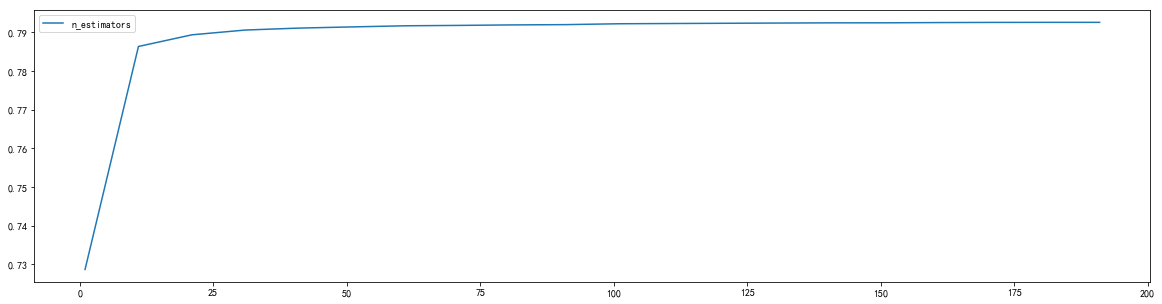

In [16]:
# 2.随机森林调整的第二步:调整n_estimators（运行时间约60分钟）

# 获取n_estimators最优值
scores = []
for i in range(0,200,10):
    regressor = ensemble.RandomForestRegressor(random_state=15
                                         ,n_estimators=i+1
                                        )
    regressor.fit(x_train,y_train)
    pre = regressor.predict(x_test)
    
    #调用函数计算正确率并添加至列表
    score = get_score(y_test,pre)
    scores.append(score)
print('max_score:'+'  '+str(max(scores))) #打印准确率最大值
print('max_n_estimators:'+'  '+str(np.argmax(scores)*10+1)) #打印准确率最大值索引

# 绘制图片
plt.figure(figsize=[20,5])
plt.plot(range(1,201,10),scores,label="n_estimators")
plt.legend()
plt.savefig('./images/solo-fpp/随机森林/solo_fpp_RFR_n_estimators_first.png')
plt.show()

#范围大致在180到200

D:\ANACONDA\lib\site-packages\ipykernel_launcher.py:9: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  if __name__ == '__main__':
D:\ANACONDA\lib\site-packages\ipykernel_launcher.py:9: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  if __name__ == '__main__':
D:\ANACONDA\lib\site-packages\ipykernel_launcher.py:9: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  if __name__ == '__main__':
D:\ANACONDA\lib\site-packages\ipykernel_launcher.py:9: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  if __name__ == '__main__':
D:\ANACONDA\lib\site-packages\ipykernel_laun

max_score:  0.7924655211135361
max_n_estimators:  200


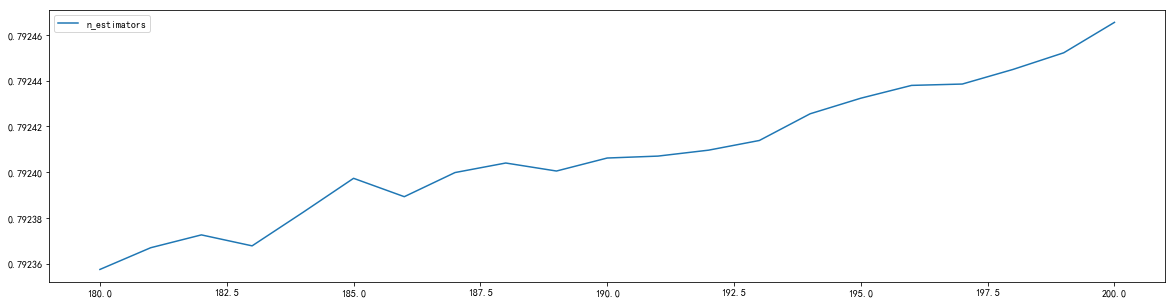

In [17]:
# 3.随机森林调整的第三步:在确定好的范围内，进一步细化学习曲线，调整n_estimators（运行时间约70分钟）

# 获取n_estimators最优值
scores = []
for i in range(180,201):
    regressor = ensemble.RandomForestRegressor(random_state=15
                                         ,n_estimators=i
                                        )
    regressor.fit(x_train,y_train)
    pre = regressor.predict(x_test)
    
    #调用函数计算正确率并添加至列表
    score = get_score(y_test,pre)
    scores.append(score)
print('max_score:'+'  '+str(max(scores))) #打印准确率最大值
print('max_n_estimators:'+'  '+str(np.argmax(scores)+180)) #打印准确率最大值索引

    
# 绘制图片
plt.figure(figsize=[20,5])
plt.plot(range(180,201),scores,label="n_estimators")
plt.legend()
plt.savefig('./images/solo-fpp/随机森林/solo_fpp_RFR_n_estimators_second.png')
plt.show()

#n_estimators最优值为200

D:\ANACONDA\lib\site-packages\ipykernel_launcher.py:10: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  # Remove the CWD from sys.path while we load stuff.
D:\ANACONDA\lib\site-packages\ipykernel_launcher.py:10: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  # Remove the CWD from sys.path while we load stuff.
D:\ANACONDA\lib\site-packages\ipykernel_launcher.py:10: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  # Remove the CWD from sys.path while we load stuff.
D:\ANACONDA\lib\site-packages\ipykernel_launcher.py:10: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using rav

max_score:  0.8039609203237497
max_max_depth:  10


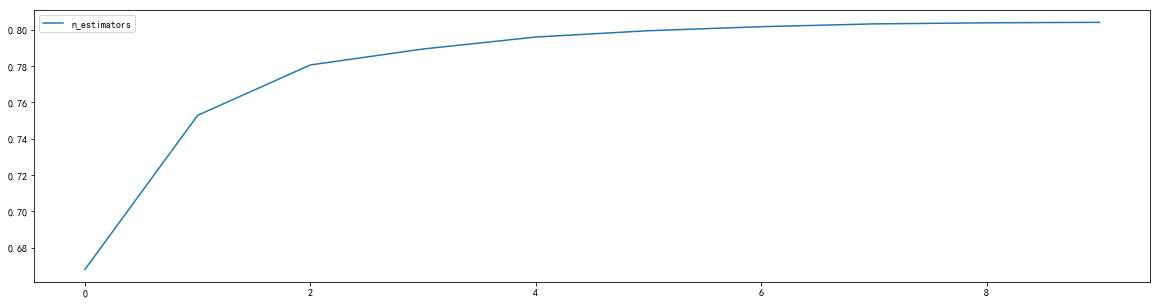

In [18]:
# 4.随机森林调整的第四步:调整max_depth（运行时间约5分钟）

# 获取max_depth最优值
scores = []
for i in range(10):
    regressor = ensemble.RandomForestRegressor(random_state=15
                                               ,n_estimators=200
                                               ,max_depth=i+1
                                              )
    regressor.fit(x_train,y_train)
    pre = regressor.predict(x_test)
    
    #调用函数计算正确率并添加至列表
    score = get_score(y_test,pre)
    scores.append(score)
print('max_score:'+'  '+str(max(scores))) #打印准确率最大值
print('max_max_depth:'+'  '+str(np.argmax(scores)+1)) #打印准确率最大值索引

    
# 绘制图片
plt.figure(figsize=[20,5])
plt.plot(range(10),scores,label="n_estimators")
plt.legend()
plt.savefig('./images/solo-fpp/随机森林/solo_fpp_RFR_max_depth.png')
plt.show()

#max_depth最优值为10

In [19]:
# 5.存储正确率和mse至列表（运行时间约20分钟）
# 定义模型
regressor = ensemble.RandomForestRegressor(random_state=15
                                               ,n_estimators=200
                                               ,max_depth=10
                                              )
# 实例化模型并存储准确率
regressor.fit(x_train,y_train)
pre = regressor.predict(x_test)
score = get_score(y_test,pre)
list_scores.append(score)

# 使用交叉验证实例化模型并存储mse
mse = model_selection.cross_val_score(regressor, X, y, cv=10,scoring = "neg_mean_squared_error").mean()
list_mse.append(mse)

D:\ANACONDA\lib\site-packages\ipykernel_launcher.py:8: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  
D:\ANACONDA\lib\site-packages\sklearn\model_selection\_validation.py:531: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
D:\ANACONDA\lib\site-packages\sklearn\model_selection\_validation.py:531: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
D:\ANACONDA\lib\site-packages\sklearn\model_selection\_validation.py:531: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  es

In [20]:
# 五、线性回归模型（LinearRegression）
#参数参考链接:https://blog.csdn.net/qq_33217634/article/details/85315604
'''
参数 含义
fit_intercept: 布尔值，可不填，默认为True，是否计算此模型的截距。如果设置为False，则不会计算截距

normalize:布尔值，可不填，默认为False当fit_intercept设置为False时，将忽略此参数。如果为True，则特征矩阵X在进入回归之前将
会被减去均值（中心化）并除以L2范式（缩放）。如果你希望进行标准化，请在fit数据之前使用preprocessing模块中的标准化专用类StandardScaler

copy_X:布尔值，可不填，默认为True如果为真，将在X.copy()上进行操作，否则的话原本的特征矩阵X可能被线性回归影响并覆盖

n_jobs:整数或者None，可不填，默认为None用于计算的作业数。只在多标签的回归和数据量足够大的时候才生效。
'''

'\n参数 含义\nfit_intercept: 布尔值，可不填，默认为True，是否计算此模型的截距。如果设置为False，则不会计算截距\n\nnormalize:布尔值，可不填，默认为False当fit_intercept设置为False时，将忽略此参数。如果为True，则特征矩阵X在进入回归之前将\n会被减去均值（中心化）并除以L2范式（缩放）。如果你希望进行标准化，请在fit数据之前使用preprocessing模块中的标准化专用类StandardScaler\n\ncopy_X:布尔值，可不填，默认为True如果为真，将在X.copy()上进行操作，否则的话原本的特征矩阵X可能被线性回归影响并覆盖\n\nn_jobs:整数或者None，可不填，默认为None用于计算的作业数。只在多标签的回归和数据量足够大的时候才生效。\n'

max_score:  [0.73117448]


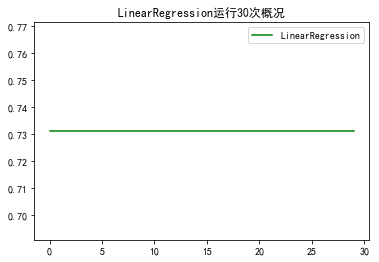

In [21]:
# 1.线性回归调整（LinearRegression,线性回归参数没啥好调的，其依赖于数据）

# 划分特征矩阵与预测矩阵
X = data.iloc[:,1:].values
y = data.iloc[:,0].values.reshape(-1,1)

# 划分训练集和测试集
x_train, x_test, y_train, y_test = model_selection.train_test_split(X,y,test_size=0.3)

# 定义计算正确率函数（RandomForestRegressor的接口score返回的是R平方，并不是MSE）
#原理有很多数学公式，jupyter打不出来，推荐直接看视频学习
#原理链接:https://www.bilibili.com/video/BV1WJ411k7L3?p=20
def get_score(y_test,pre):
    error_sum = 0
    for i,j in zip(y_test,pre):
        error_sum+=math.sqrt((i-j)**2)
    pre_sum=sum(pre)
    score = (1-(error_sum/pre_sum)) #R*2 = 1-u/v,其中u是残差平方和（MSE * N），v是总平方和
    return score

# 运行30次查看准确率
scores = [] #定义准确率列表
for i in range(30):
    # 实例化模型并训练
    regressor = linear_model.LinearRegression()
    regressor.fit(x_train,y_train)
    pre = regressor.predict(x_test)
    
    #调用函数计算正确率并添加至列表
    score = get_score(y_test,pre)
    scores.append(score)
print('max_score:'+'  '+str(max(scores))) #打印准确率最大值 

#绘制图片
plt.plot(range(30),scores,color="green",label="LinearRegression")
plt.title('LinearRegression运行30次概况')
plt.legend()
plt.savefig('./images/solo-fpp/线性回归/solo_fpp_LR.png')
plt.show()

In [22]:
# 2.存储正确率和mse至列表（运行时间约10分钟）
# 定义模型
regressor = linear_model.LinearRegression()
# 实例化模型并存储准确率
regressor.fit(x_train,y_train)
pre = regressor.predict(x_test)
score = get_score(y_test,pre) #返回的是array
score = float(score)
list_scores.append(score)

# 使用交叉验证实例化模型并存储mse
mse = model_selection.cross_val_score(regressor, X, y, cv=10,scoring = "neg_mean_squared_error").mean()
list_mse.append(mse)

In [23]:
# 六、岭回归(Ridge)
# 参考链接:https://blog.csdn.net/SA14023053/article/details/51707597







max_score:  [0.73047319]


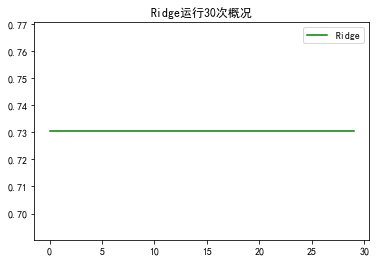

In [24]:
# 1.岭回归调整（Ridge,岭回归参数没啥好调的，其依赖于数据）

# 划分特征矩阵与预测矩阵
X = data.iloc[:,1:].values
y = data.iloc[:,0].values.reshape(-1,1)

# 划分训练集和测试集
x_train, x_test, y_train, y_test = model_selection.train_test_split(X,y,test_size=0.3)

# 定义计算正确率函数（RandomForestRegressor的接口score返回的是R平方，并不是MSE）
#原理有很多数学公式，jupyter打不出来，推荐直接看视频学习
#原理链接:https://www.bilibili.com/video/BV1WJ411k7L3?p=20
def get_score(y_test,pre):
    error_sum = 0
    for i,j in zip(y_test,pre):
        error_sum+=math.sqrt((i-j)**2)
    pre_sum=sum(pre)
    score = (1-(error_sum/pre_sum)) #R*2 = 1-u/v,其中u是残差平方和（MSE * N），v是总平方和
    return score

# 运行30次查看准确率
scores = [] #定义准确率列表
for i in range(30):
    # 实例化模型并训练
    regressor = linear_model.Ridge()
    regressor.fit(x_train,y_train)
    pre = regressor.predict(x_test)
    
    #调用函数计算正确率并添加至列表
    score = get_score(y_test,pre)
    scores.append(score)
print('max_score:'+'  '+str(max(scores))) #打印准确率最大值 

#绘制图片
plt.plot(range(30),scores,color="green",label="Ridge")
plt.title('Ridge运行30次概况')
plt.legend()
plt.savefig('./images/solo-fpp/岭回归/solo_fpp_R.png')
plt.show()

In [25]:
# 2.存储正确率和mse至列表（运行时间约10分钟）
# 定义模型
regressor = linear_model.Ridge()
# 实例化模型并存储准确率
regressor.fit(x_train,y_train)
pre = regressor.predict(x_test)
score = get_score(y_test,pre) #返回的是array
score = float(score)
list_scores.append(score)

# 使用交叉验证实例化模型并存储mse
mse = model_selection.cross_val_score(regressor, X, y, cv=10,scoring = "neg_mean_squared_error").mean()
list_mse.append(mse)

In [26]:
# 七、XGBoost模型（XGBRegressor）
#参数参考链接:https://blog.csdn.net/qq_33799246/article/details/88930721（但他有个小错，是n_estimators，不是n_estimator）







max_score:  0.8304469120829976
max_n_estimators:  23


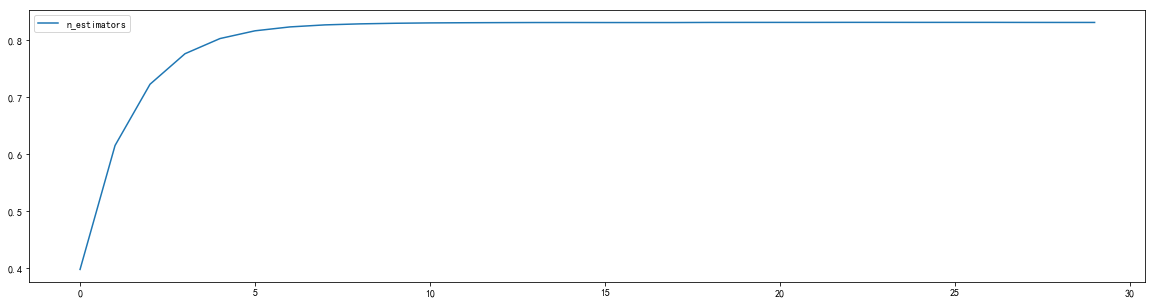

In [29]:
# 1.XGBoost调整第一步，调整n_estimators（运行时间约2分钟）

# 获取n_estimators最优值
scores = []
for i in range(30):
    regressor = XGBRegressor(random_state=420
                             ,n_estimators=i+1)
    regressor.fit(x_train,y_train)
    score = regressor.score(x_test,y_test)
    scores.append(score)
print('max_score:'+'  '+str(max(scores))) #打印准确率最大值
print('max_n_estimators:'+'  '+str(np.argmax(scores)+1)) #打印准确率最大值索引

# 绘制图片
plt.figure(figsize=[20,5])
plt.plot(range(30),scores,label="n_estimators")
plt.legend()
plt.savefig('./images/solo-fpp/XGBoost/solo_fpp_XGBR_n_estimators_first.png')
plt.show()

#n_estimators的最优值是23

max_score:  0.8302746421693263
max_learning_rate:  0.2


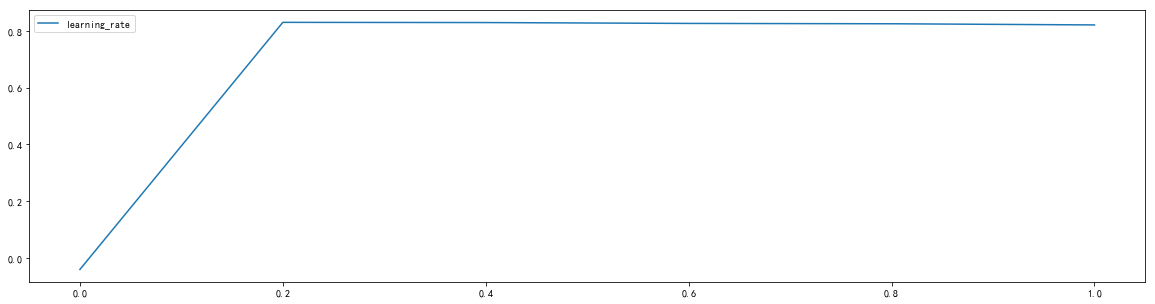

In [30]:
# 2.XGBoost调整第二步，调整learning_rate（运行时间约2分钟）

# 获取learning_rate最优值
scores = []
list_learning_rate = [0,0.2,0.4,0.6,0.8,1]
for i in list_learning_rate:
    regressor = XGBRegressor(random_state=420
                             ,n_estimators=23
                             ,learning_rate=i)
    regressor.fit(x_train,y_train)
    score = regressor.score(x_test,y_test)
    scores.append(score)
print('max_score:'+'  '+str(max(scores))) #打印准确率最大值
print('max_learning_rate:'+'  '+str(np.argmax(scores)*0.2)) #打印准确率最大值索引

# 绘制图片
plt.figure(figsize=[20,5])
plt.plot(list_learning_rate,scores,label="learning_rate")
plt.legend()
plt.savefig('./images/solo-fpp/XGBoost/solo_fpp_XGBR_learning_rate.png')
plt.show()

#learning_rate的最优值为0.2

In [31]:
# 3.存储正确率和mse至列表
# 定义模型
regressor = XGBRegressor(random_state=420
                             ,n_estimators=23
                             ,learning_rate=0.2)
# 实例化模型并存储准确率
regressor.fit(x_train,y_train)
score = regressor.score(x_test,y_test)
list_scores.append(score)

# 使用交叉验证实例化模型并存储mse
mse = model_selection.cross_val_score(regressor, X, y, cv=10,scoring = "neg_mean_squared_error").mean()
list_mse.append(mse)

In [32]:
# 八、模型评估（采用准确率和mse评价）







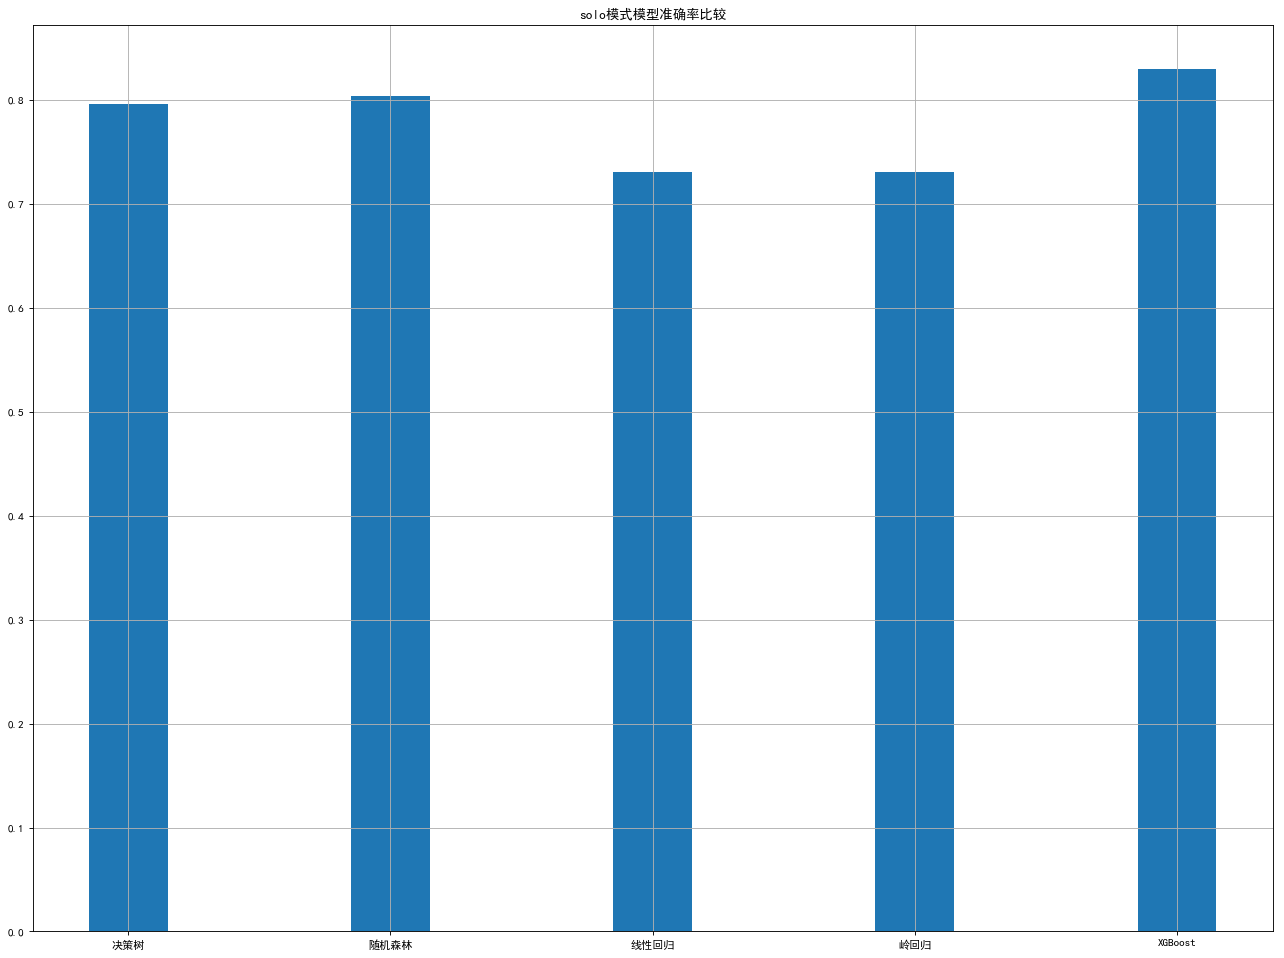

In [33]:
# 1.准确率评价

list_models = ['决策树','随机森林','线性回归','岭回归','XGBoost']

#设置图片大小
plt.figure(figsize=(20,15),dpi=80)

#绘制图片
plt.bar(list_models,list_scores,width=0.3)

#添加描述信息
plt.title("solo模式模型准确率比较")

#绘制表格
plt.grid(alpha=1) #alpha是表格透明度

#保存图片
plt.savefig("./images/solo-fpp/模型评价/precision_compare.png") 

#展示图片
plt.show()

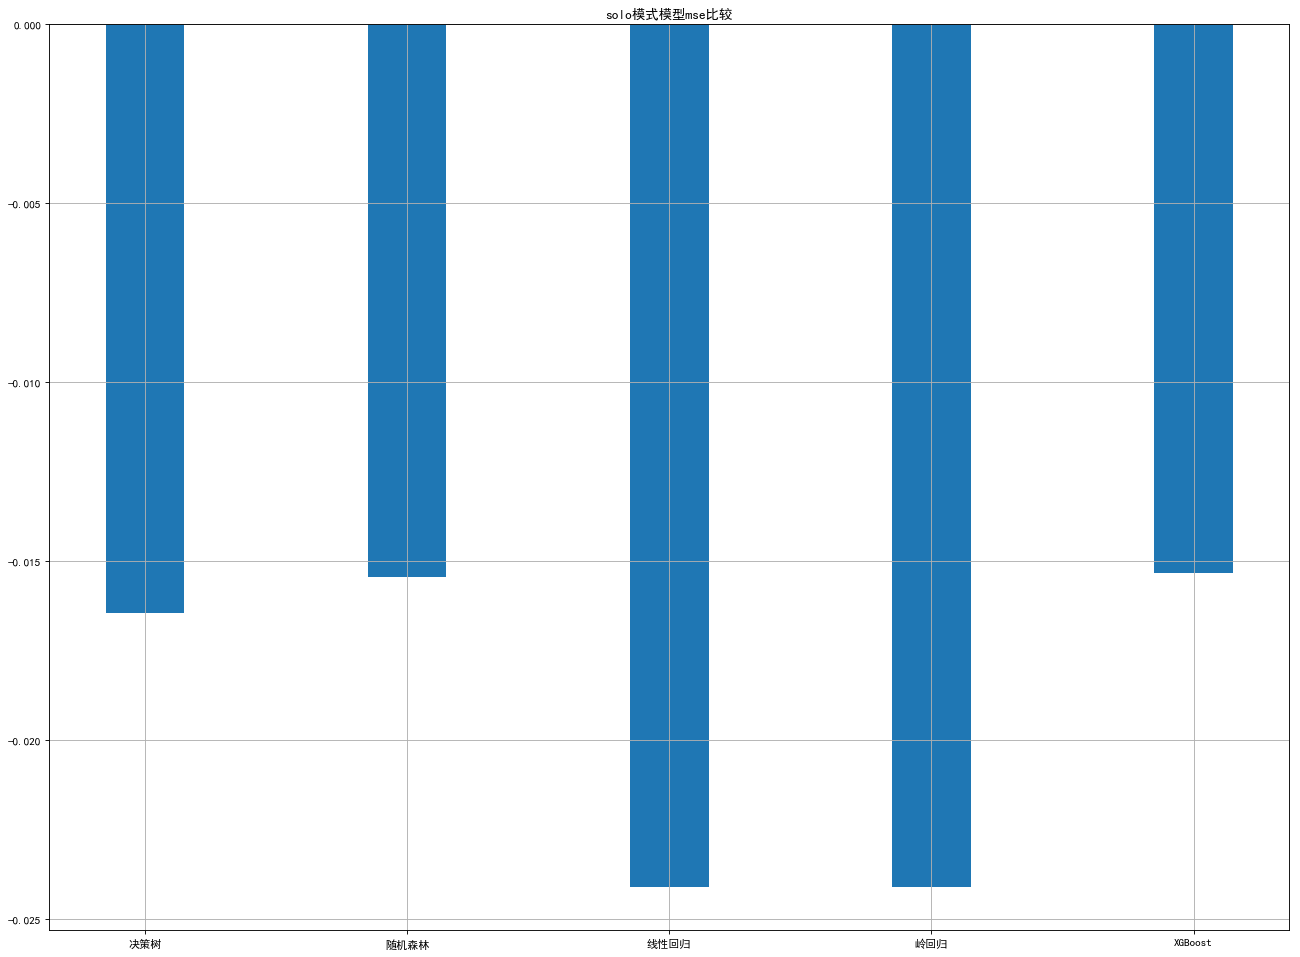

In [34]:
# 2.mse评价(越接近0越好)

list_models = ['决策树','随机森林','线性回归','岭回归','XGBoost']

#设置图片大小
plt.figure(figsize=(20,15),dpi=80)

#绘制图片
plt.bar(list_models,list_mse,width=0.3)

#添加描述信息
plt.title("solo模式模型mse比较")

#绘制表格
plt.grid(alpha=1) #alpha是表格透明度

#保存图片
plt.savefig("./images/solo-fpp/模型评价/mse_compare.png") 

#展示图片
plt.show()